# Personalized Medicine: Redefining Cancer treatment
Submitted by:
* Saurabh Jaju
Date: August 21, 2015
Kaggle competition link: [Personalized Medicine: Redefining Cancer treatment](https://www.kaggle.com/c/msk-redefining-cancer-treatment)

Competition description:
It is a multi class classification problem. With 9 distinct classes.
File descriptions

- training_variants - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations), Class (1-9 the class this genetic mutation has been classified on)
- training_text - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)
- test_variants - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations)
- test_text - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

In [49]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
# Function for k NN classifier
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

### User defined functions for data manipulations

- The functions below are to create and curate data in various formats. The textTofeatures function can be used to create any number of most frequent (by count) words or n grams.
- The preProcessor function cleans the data and creates a few new features.

In [3]:
# # #### creating ngrams features for the combined set
## input: dfCombined must have a clean_text column with whatever text processing you need done
def textTofeatures(dfCombined,ngramRangeStart=1,ngramRangeEnd=1,stopWords='english',onlyNgrams=False,removeCleanText=True,maxFeatures=250):
    from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
    cv = CountVectorizer( stop_words=stopWords, ngram_range=(ngramRangeStart,ngramRangeEnd), analyzer='word',max_features=maxFeatures)
    dt_mat = cv.fit_transform(dfCombined.clean_text)
    tfidf_transformer = TfidfTransformer()
    tfidf_mat = tfidf_transformer.fit_transform(dt_mat)
    ngrams = pd.DataFrame(dt_mat.todense(), index=dfCombined.index, columns=cv.get_feature_names())
    if(onlyNgrams==False):
        ngrams=pd.concat([dfCombined,ngrams],axis=1)
        if(removeCleanText==True): 
            ngrams.drop('clean_text',axis=1,inplace=True)
    return ngrams

# bigrams=textTofeatures(combined,1,1,onlyNgrams=False,removeCleanText=False)
# print(bigrams.head())
# print(bigrams.iloc[:,0:20].head())


## Preprocessor function with minor feature engineering
def preProcessor(combined):
    # Creating basic features
# Remove useless symbols from description
    def clean(s):    
        # Remove any tags:
        cleaned = re.sub(r"(?s)<.*?>", " ", s)
        # Keep only regular chars:
        cleaned = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", cleaned)
        # Remove unicode chars
        cleaned = re.sub("\\\\u(.){4}", " ", cleaned)
        # Remove extra whitespace
        cleaned = re.sub(r"&nbsp;", " ", cleaned)
        cleaned = re.sub(r"\s{2,}", " ", cleaned)
        return cleaned.strip()

    combined['clean_text'] = combined.text.apply(lambda x: clean(x))
    # convert text to lowercase
    combined['clean_text'] = combined.clean_text.str.lower()
    # count number of characters in text
    combined['char_count'] = combined.clean_text.str.len()
    # count number of characters removed
    combined['char_count_dirty'] = combined.text.str.len() - combined.clean_text.str.len()
    # create list of all words in text
    combined['text_list'] = combined.clean_text.str.split(' ')
    # count number of words in text
    combined['word_count'] = combined.text_list.str.len()
    # find average word length in text
    combined['avg_word_len'] = combined.char_count / combined.word_count
    # to identify train and test set
    combined.Class.fillna(-1,inplace= True) 
    return combined



## Getting the data

- In the following section the data is read and word vector data set, bigram and trigram datasets are created for use later.

In [4]:
# load data
train_variants = pd.read_csv('training_variants', sep = ',')
test_variants = pd.read_csv('test_variants', sep = ',')
train_text = pd.read_csv('training_text', sep = '\|\|', skiprows=1, engine='python', names=["ID","text"])
test_text = pd.read_csv('test_text', sep = '\|\|', skiprows=1, engine='python' ,names=["ID","text"])


# combine variant and text datasets
train = train_variants.merge(train_text, on='ID', how='left')
test = test_variants.merge(test_text, on='ID', how='left')

combined = pd.concat([train, test], axis=0)

combined=preProcessor(combined)
test=combined[combined.Class==-1]
train=combined[combined.Class!=-1]

## Creating top 250 words, top 250 bigrams, top 250 trigrams datasets
wordTrain=textTofeatures(train,1,1,onlyNgrams=True,maxFeatures=250)
bigramsTrain=textTofeatures(train,2,2,onlyNgrams=True,maxFeatures=250)
trigramTrain=textTofeatures(train,3,3,onlyNgrams=True,maxFeatures=250)

wordTrain['Class']=train['Class']
bigramsTrain['Class']=train['Class']
trigramTrain['Class']=train['Class']

## Curating Data and creating local train and test data
- Local train and test set are created using a random seed.

In [64]:
#Creating the features using the function

## Curating both train and test data
bigramsTrain=textTofeatures(train,2,2,onlyNgrams=False,removeCleanText=False,maxFeatures=250)
bigramsTest=textTofeatures(test,2,2,onlyNgrams=False,removeCleanText=False,maxFeatures=250)
testNames=bigramsTest.columns.tolist()
trainNames=bigramsTrain.columns.tolist()

## Having the same features in both the train and the test set
bigramsTrain=bigramsTrain[bigramsTrain.columns.intersection(testNames)]
bigramsTest=bigramsTest[bigramsTest.columns.intersection(trainNames)]

bigramsTrain=bigramsTrain.select_dtypes(['number'])
bigramsTest=bigramsTest.select_dtypes(['number'])
# print(bigramsTest.head())
# print(bigramsTrain.head())


## Removing non numeric columns from data set to input to models
trainLocal, testLocal = train_test_split(bigramsTrain, test_size = 0.2)
print(trainLocal.shape)
print(testLocal.shape)
testLocalClass=testLocal['Class']
trainLocalClass=trainLocal['Class']


(2656, 202)
(665, 202)


## Exploratory Data Analysis
- As the feature space for the problem is extremely large. Exploring the most frequent instances is the priority. 
- This section also includes the exploratory analysis of bigram and trigram features created using previous functions.
### User defined functions for plotting

In [6]:
def barPlot(names,frequency,topN,title):
    freqDf=pd.DataFrame(names,index=names,columns=list('W'))
    freqDf['frequency']=pd.Series(frequency, index=freqDf.index)
    freqDf=freqDf.sort_values(['frequency'], ascending=[False])
    import matplotlib.pyplot as plt
    import matplotlib
    matplotlib.style.use('ggplot')
    plt.figure(figsize=(20, 10)) 
    plt.title(title)
    ax = plt.subplot(freqDf['frequency'].head(topN).plot.bar(), xlabel='x', ylabel='y', title='title')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    return plt.show()



### Exploring Dataset without feature engineering

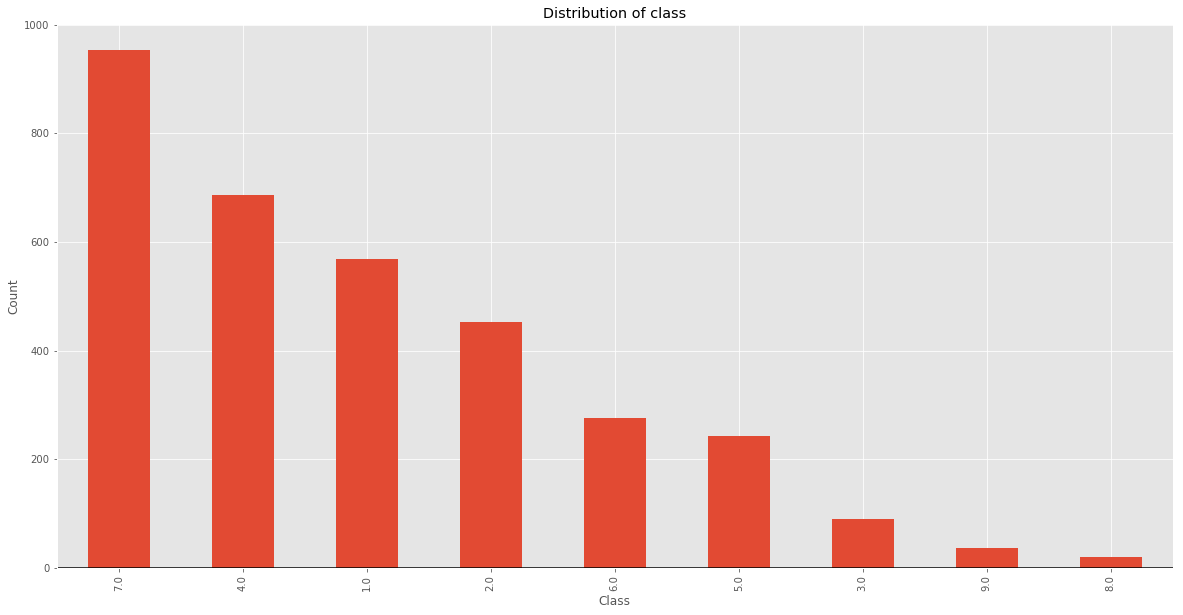

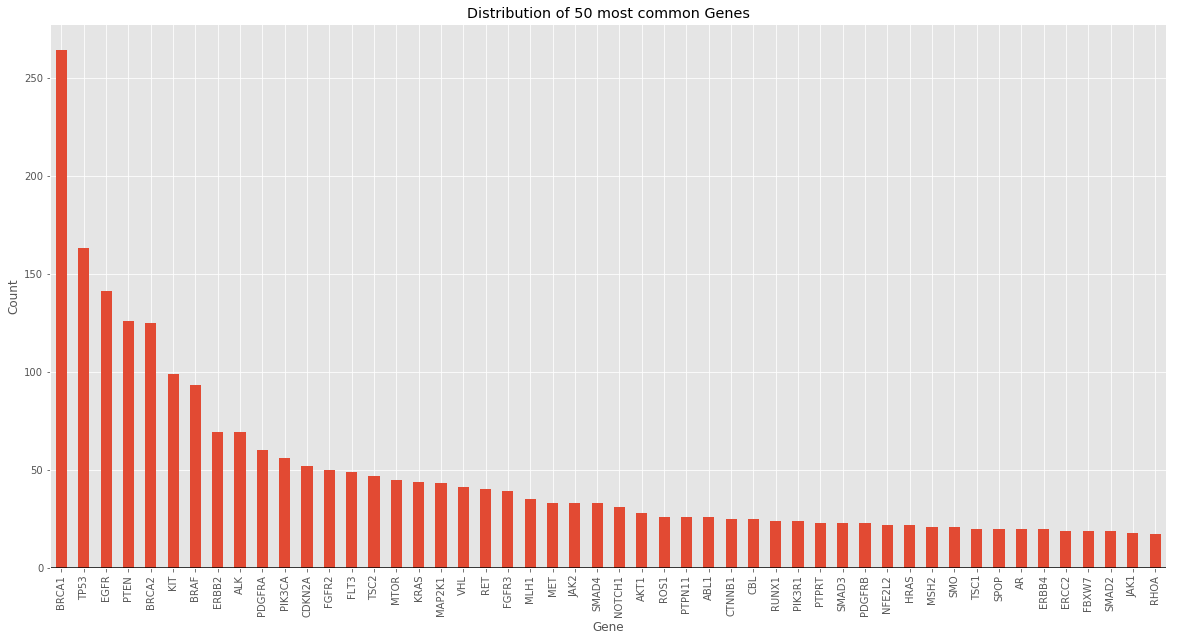

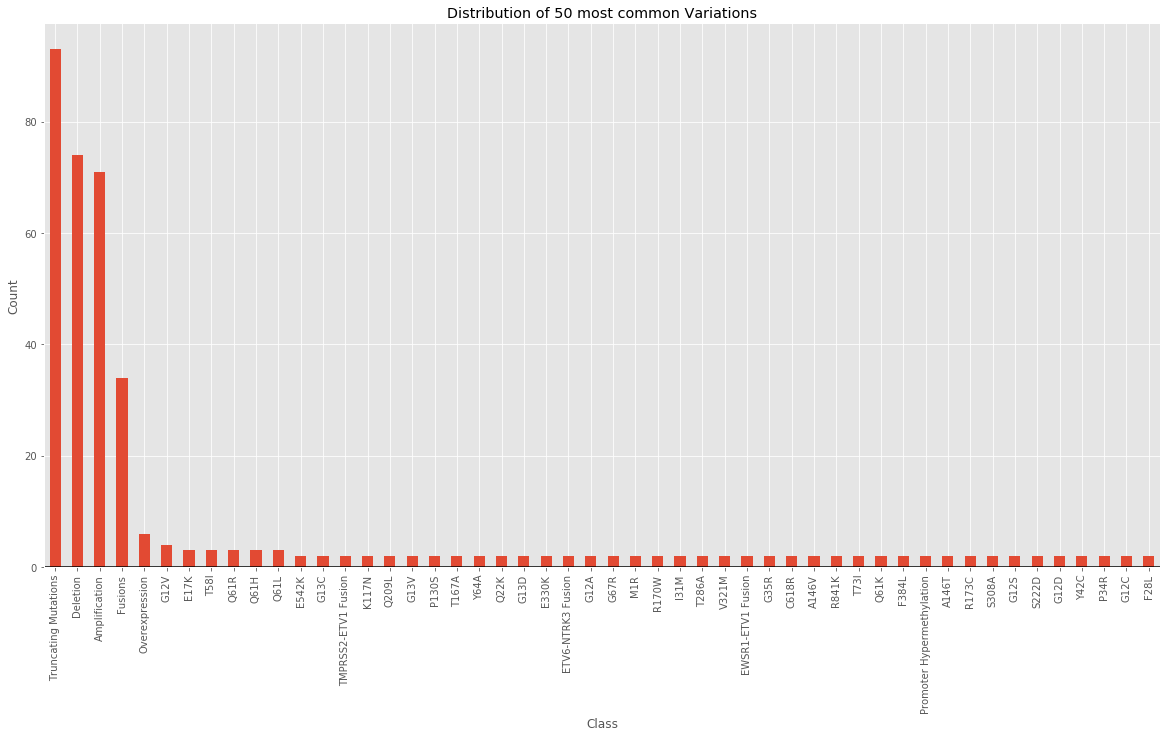

In [7]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
plt.figure(figsize=(20, 10)) 
plt.title("Distribution of class")
plt.xlabel("Class")
plt.ylabel("Count")
train['Class'].value_counts().plot.bar(); plt.axhline(0, color='k')
plt.show()



plt.figure(figsize=(20, 10)) 
plt.title("Distribution of 50 most common Genes")
plt.xlabel("Gene")
plt.ylabel("Count")
train['Gene'].value_counts().head(50).plot.bar(); plt.axhline(0, color='k')
plt.show()

#####################################################################################
### 
plt.figure(figsize=(20, 10)) 
plt.title("Distribution of 50 most common Variations")
plt.xlabel("Variation")
plt.ylabel("Count")
train['Variation'].value_counts().head(50).plot.bar(); plt.axhline(0, color='k')
plt.show()
#####################################################################################


#### A few observations based on the plots above would be:
- The classes for prediction are not evenly distributed. The last three classes can be probabaly clubbed to get an hybrid class, and the probability of getting that class would state the equal probability of getting any of the classes.


### Exploring simple count vectors, Bigrams and trigrams

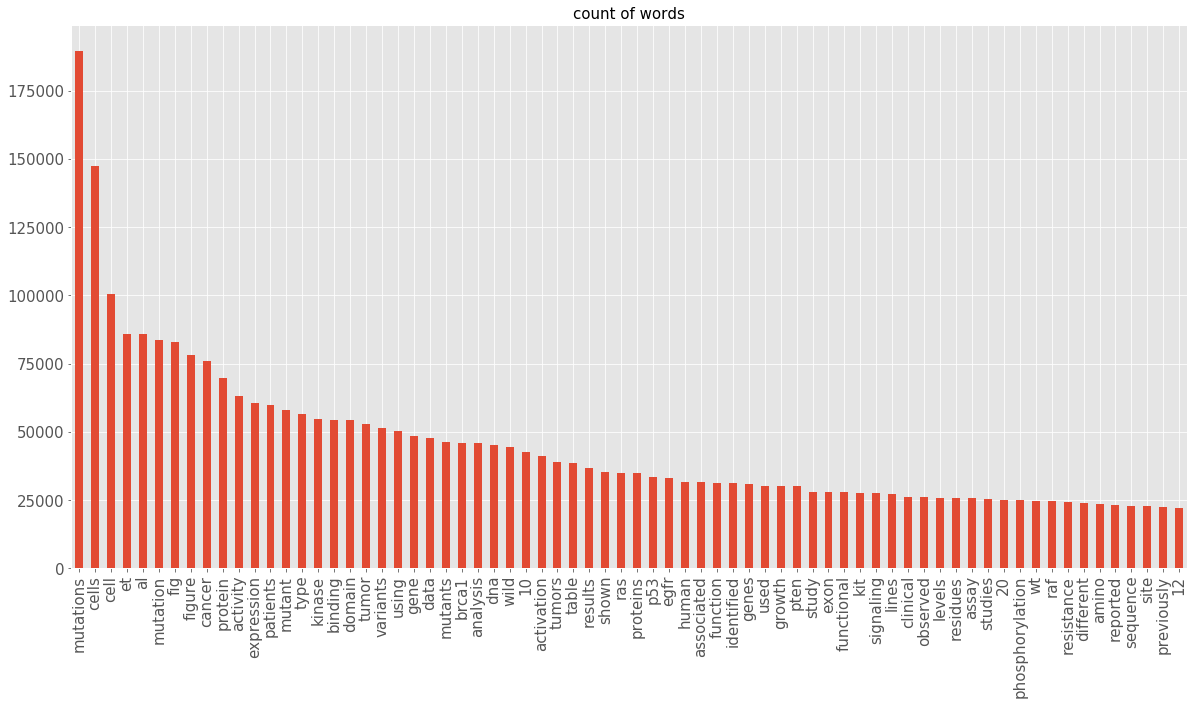

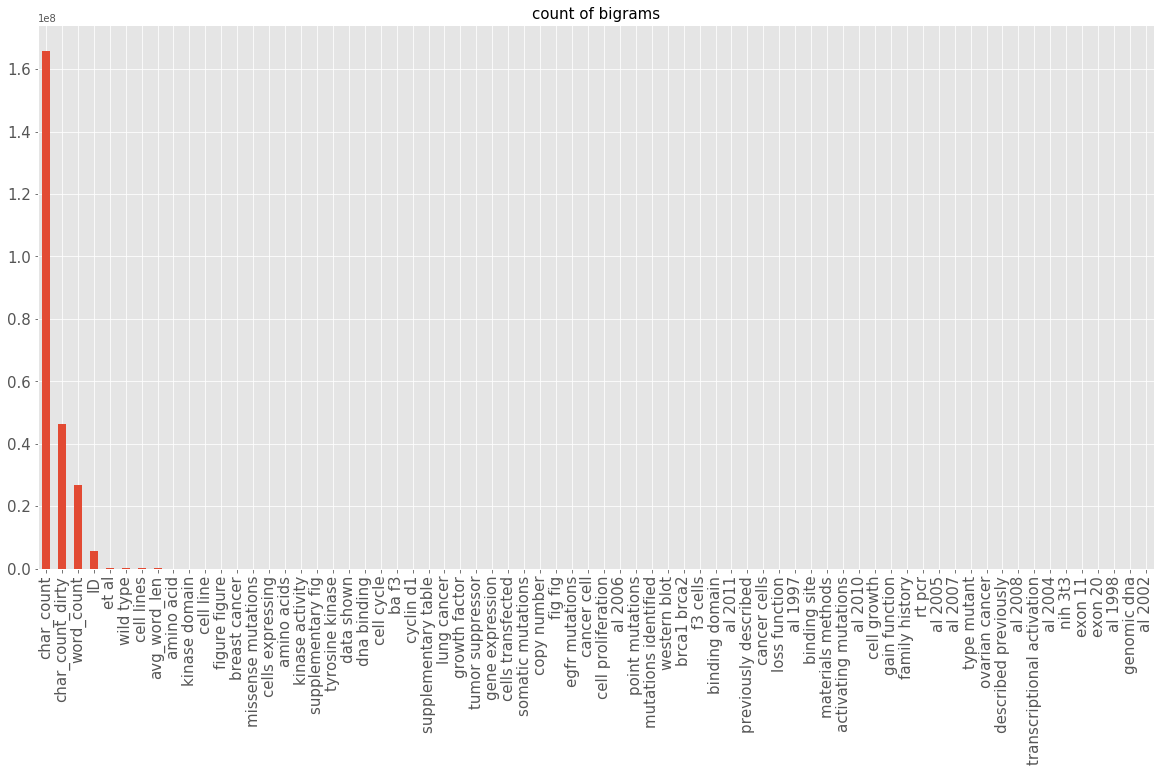

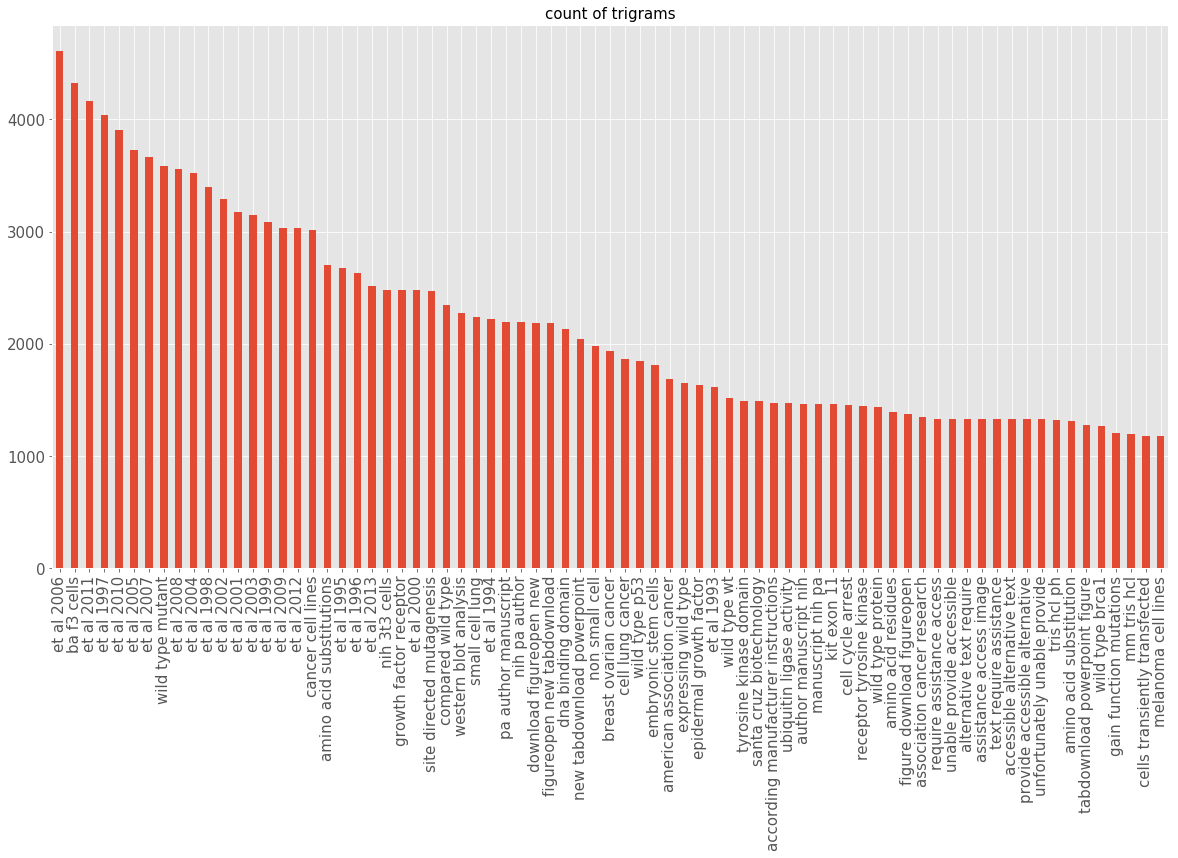

In [8]:
barPlot(wordTrain.columns.values,wordTrain.sum(axis=0),70,"count of words")
del bigramsTrain['Class']
barPlot(bigramsTrain.columns.values,bigramsTrain.sum(axis=0),70,"count of bigrams")
del trigramTrain['Class']
barPlot(trigramTrain.columns.values,trigramTrain.sum(axis=0),75,"count of trigrams")

### A few observations based on the plots above.
- The "et al yyyy" format references are very commonly found in the text. All the references can be added to get an idea of the number of references per frame of Data.  
- Also tri gram models may be a better set of features, given the references are identifyable only in trigrams and bigram feature give un no clue of such pattern.


## Modeling
### User defined functions for modeling
Following are the function definitions for k-NN classifier, Multinomial Bayes classifier, random forest classfier and xgboost classfier. As expected for each of these:
- The multinomial Bayes classifier is the least accurate
- The kNN classifier is relatively better at classifying the data
- The Random forest classfier being a CART based algorithm with inbuilt sampling gives a better output. (Bagging based approach)
- While XGBoost being a cart based boosting algorithm performs much better at classifying the data. (Boosting based approach) 

In [96]:
######### knn Classifier

def knnClf(train,test,trainClass,testClass,isLocal=True):
## Data prep
    train=train.select_dtypes(['number'])
    test=test.select_dtypes(['number'])
    ####### kNN ########
    param = {'n_neighbors': np.concatenate([np.arange(1,50,1),np.arange(50,100,2),
                                            np.arange(100,201,5)]).tolist()}
    best_param_kNN = GridSearchCV(KNeighborsClassifier(), param, scoring='f1_macro')
    best_param_kNN.fit(train.values, trainClass.values)
    optimal_k = best_param_kNN.best_params_['n_neighbors']
#     print (optimal_k)
    kNN_model = KNeighborsClassifier(n_neighbors=optimal_k)
    kNN_model.fit(train.values, trainClass.values)
    test_predicted_labels = kNN_model.predict(test.values) ## Executing on test set here
    if(isLocal==True):
        return(metrics.f1_score(y_true=testClass.values, y_pred= test_predicted_labels,average='macro'))
    return(test_predicted_labels)


######################## Multinomial Naive Bayes classifier
def MultNBClf(train,test,trainClass,testClass,isLocal=True):
## Data prep
    train=train.select_dtypes(['number'])
    test=test.select_dtypes(['number'])
    
    alpha = np.concatenate([np.arange(0.01,0.002),np.arange(0.01,0.1,0.01),
                            np.arange(0.1,1.1,0.1)])
    # Similar grid search approach
    param = {'alpha': list(alpha)}
    best_param_NB = GridSearchCV(MultinomialNB(), param, scoring='f1_macro')
    best_param_NB.fit(train.values, trainClass.values)
    optimal_alpha = best_param_NB.best_params_['alpha']
    # best_param_NB.best_score_
    NB_model = MultinomialNB(alpha=optimal_alpha)
    NB_model.fit(train.values, trainClass.values)
    test_predicted_labels = NB_model.predict(test.values)
    if(isLocal==True):
        return(metrics.f1_score(y_true=testClass.values, y_pred=test_predicted_labels,average='macro'))
    return(test_predicted_labels)
# MultNBClf(trainLocal,testLocal,trainLocalClass,testLocalClass)

###################################### Random forest classifier
def randomForestClassifier(train,test,trainLocalClass,IsfeatureImportance=False,needProbabilities=False):
    features=testLocal.columns.tolist()
    ## Creating a random forest classifier
    from sklearn.ensemble import RandomForestClassifier
    # Create a random forest classifier. By convention, clf means 'classifier'
    clf = RandomForestClassifier(n_jobs=8)
    # Train the classifier to take the training features and learn how they relate
    # to the training y (the species)
    clf.fit(trainLocal[features], trainLocalClass)
    clf.predict(testLocal[features])
    clf.predict_proba(testLocal[features])
    if(IsfeatureImportance==True):
        return list(zip(trainLocal[features], clf.feature_importances_))
    if(needProbabilities==True):
        return clf.predict_proba(testLocal[features])
    return clf.predict(testLocal[features])

# rfOPL=randomForestClassifier(trainLocal,testLocal,trainLocalClass)
# metrics.f1_score(y_true=testLocalClass.values, y_pred=rfOPL,average='macro')


################################## XGBoost classifier



## 
def xgbModel(train,test,eta,maxDepth,nFolds):
    
    #############################################################################################
#     preparing data for model
    train=train.select_dtypes(['number'])
    test=test.select_dtypes(['number'])
    ############################################################################################
    # need to do this to avoid an error by XGB -- classes should start at 0, not 1

    train.Class = train.Class - 1


    x_train = train.drop(['Class'], axis=1)
    x_test = train['Class']
    test=test.drop(['Class'], axis=1)
    xgb_params = {
        # don't change
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class' : 9,
        'eta': eta,
        'max_depth': maxDepth,
        'n_folds': nFolds,
        'silent': 1,    
    }

    dtrain = xgb.DMatrix(x_train, x_test)

    early = 20
    cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=2000, early_stopping_rounds = early, verbose_eval=1)

    num_boost_rounds = len(cv_output)
    model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round = int(num_boost_rounds / 0.80))

    test_data = xgb.DMatrix(test)

    y_predict = pd.concat([test.ID, pd.DataFrame(model.predict(test_data))], axis=1)
    output = pd.DataFrame(y_predict)

    output.columns = ['ID', 'class1', 'class2', 'class3', 'class4',
                  'class5', 'class6', 'class7', 'class8', 'class9']

    return output

#output = xgbModel(bigramsTrain,bigramsTest,eta=0.05,maxDepth=9,nFolds=3)
output = xgbModel(TrigramsTrain,TrigramsTest,eta=0.05,maxDepth=9,nFolds=3)
#output = xgbModel(trainLocal,testLocal,eta=0.05,maxDepth=9,nFolds=3)
# print(output.head())
# output.to_csv('XGB_submission.csv', index=False)

[0]	train-mlogloss:2.10406+0.00118843	test-mlogloss:2.12797+0.000487964
[1]	train-mlogloss:2.01831+0.000965161	test-mlogloss:2.06569+0.00258194
[2]	train-mlogloss:1.9412+0.000715032	test-mlogloss:2.00964+0.00350318
[3]	train-mlogloss:1.87126+0.000477659	test-mlogloss:1.96008+0.00418001
[4]	train-mlogloss:1.80605+0.000337345	test-mlogloss:1.91352+0.00385059
[5]	train-mlogloss:1.7463+0.000641582	test-mlogloss:1.87097+0.00471617
[6]	train-mlogloss:1.6901+0.00192033	test-mlogloss:1.8314+0.00541083
[7]	train-mlogloss:1.63759+0.00260377	test-mlogloss:1.79389+0.00489473
[8]	train-mlogloss:1.58839+0.00357463	test-mlogloss:1.75862+0.00468541
[9]	train-mlogloss:1.54264+0.00421094	test-mlogloss:1.72627+0.00546661
[10]	train-mlogloss:1.49978+0.00429062	test-mlogloss:1.69685+0.00517757
[11]	train-mlogloss:1.45848+0.00438368	test-mlogloss:1.66843+0.00574552
[12]	train-mlogloss:1.41936+0.00444442	test-mlogloss:1.64173+0.00587678
[13]	train-mlogloss:1.3826+0.00385711	test-mlogloss:1.61691+0.00587662
[

[115]	train-mlogloss:0.385865+0.00649771	test-mlogloss:1.08848+0.0143947
[116]	train-mlogloss:0.38339+0.00643851	test-mlogloss:1.08842+0.0144806
[117]	train-mlogloss:0.381042+0.0064217	test-mlogloss:1.08819+0.0146491
[118]	train-mlogloss:0.378378+0.00652119	test-mlogloss:1.08828+0.0148596
[119]	train-mlogloss:0.375841+0.00629894	test-mlogloss:1.08796+0.0148059
[120]	train-mlogloss:0.373868+0.00658465	test-mlogloss:1.08782+0.0151331
[121]	train-mlogloss:0.371296+0.00604934	test-mlogloss:1.0877+0.0153551
[122]	train-mlogloss:0.368941+0.00610392	test-mlogloss:1.0876+0.0155518
[123]	train-mlogloss:0.366612+0.00604399	test-mlogloss:1.08741+0.0155604
[124]	train-mlogloss:0.364359+0.00624861	test-mlogloss:1.08723+0.015462
[125]	train-mlogloss:0.362247+0.00629329	test-mlogloss:1.08714+0.0154275
[126]	train-mlogloss:0.359956+0.00599072	test-mlogloss:1.08705+0.015498
[127]	train-mlogloss:0.358099+0.00616624	test-mlogloss:1.08702+0.0156643
[128]	train-mlogloss:0.355755+0.00612917	test-mlogloss:1.

## Using only Bigram features for text

- Once we have accertained the performance of all the above mentioned classifier, We can improve the performance by either feature selection from the existing set or by using diffrent sets of features. 
- Since the text data provides immense scope for generating new features, in the following analysis, let us observe how the classifiers perform while using different set of bigrams or single word or trigram features.

In [65]:
del trainLocal['Class']
del testLocal['Class']
print("F-score for k-NN", knnClf(trainLocal,testLocal,trainLocalClass,testLocalClass))
print("F-score for Multinomial Naive Bayes algorithm is" , MultNBClf(trainLocal,testLocal,trainLocalClass,testLocalClass))
rfOPL=randomForestClassifier(trainLocal,testLocal,trainLocalClass)
print("F-score for Random forest algorithm is ",metrics.f1_score(y_true=testLocalClass.values, y_pred=rfOPL,average='macro'))




('F-score for k-NN', 0.40497222318308801)
('F-score for Multinomial Naive Bayes algorithm is', 0.095642568498632397)
('F-score for Random forest algorithm is ', 0.46447296927015064)


## Single word features

In [67]:
#Creating the features using the function

## Curating both train and test data
wordTrain=textTofeatures(train,1,1,onlyNgrams=False,removeCleanText=False,maxFeatures=250)
wordTest=textTofeatures(test,1,1,onlyNgrams=False,removeCleanText=False,maxFeatures=250)
testNames=wordTest.columns.tolist()
trainNames=wordTrain.columns.tolist()

## Having the same features in both the train and the test set
wordTrain=wordTrain[wordTrain.columns.intersection(testNames)]
wordTest=wordTest[TrigramsTest.columns.intersection(trainNames)]

wordTrain=wordTrain.select_dtypes(['number'])
wordTest=wordTest.select_dtypes(['number'])
# print(bigramsTest.head())
# print(bigramsTrain.head())


## Removing non numeric columns from data set to input to models
trainLocal, testLocal = train_test_split(wordTrain, test_size = 0.2)
testLocalClass=testLocal['Class']
trainLocalClass=trainLocal['Class']


In [68]:
del trainLocal['Class']
del testLocal['Class']
print("F-score for k-NN", knnClf(trainLocal,testLocal,trainLocalClass,testLocalClass))
print("F-score for Multinomial Naive Bayes algorithm is" , MultNBClf(trainLocal,testLocal,trainLocalClass,testLocalClass))
rfOPL=randomForestClassifier(trainLocal,testLocal,trainLocalClass)
print("F-score for Random forest algorithm is ",metrics.f1_score(y_true=testLocalClass.values, y_pred=rfOPL,average='macro'))



('F-score for k-NN', 0.41748380531307255)
('F-score for Multinomial Naive Bayes algorithm is', 0.063386610460181347)
('F-score for Random forest algorithm is ', 0.5398770352865907)


## Trigram features

In [82]:
#Creating the features using the function

## Curating both train and test data
TrigramsTrain=textTofeatures(train,3,3,onlyNgrams=False,removeCleanText=False,maxFeatures=250)
TrigramsTest=textTofeatures(test,3,3,onlyNgrams=False,removeCleanText=False,maxFeatures=250)
testNames=TrigramsTest.columns.tolist()
trainNames=TrigramsTrain.columns.tolist()

## Having the same features in both the train and the test set
TrigramsTrain=TrigramsTrain[TrigramsTrain.columns.intersection(testNames)]
TrigramsTest=TrigramsTest[TrigramsTest.columns.intersection(trainNames)]

TrigramsTrain=TrigramsTrain.select_dtypes(['number'])
TrigramsTest=TrigramsTest.select_dtypes(['number'])
# print(bigramsTest.head())
# print(bigramsTrain.head())


## Removing non numeric columns from data set to input to models
trainLocal, testLocal = train_test_split(TrigramsTrain, test_size = 0.2)
print(trainLocal.shape)
print(testLocal.shape)
testLocalClass=testLocal['Class']
trainLocalClass=trainLocal['Class']


(2656, 182)
(665, 182)


In [62]:
del trainLocal['Class']
del testLocal['Class']
print("F-score for k-NN", knnClf(trainLocal,testLocal,trainLocalClass,testLocalClass))
print("F-score for Multinomial Naive Bayes algorithm is" , MultNBClf(trainLocal,testLocal,trainLocalClass,testLocalClass))
rfOPL=randomForestClassifier(trainLocal,testLocal,trainLocalClass)
print("F-score for Random forest algorithm is ",metrics.f1_score(y_true=testLocalClass.values, y_pred=rfOPL,average='macro'))



('F-score for k-NN', 0.4463829192306239)
('F-score for Multinomial Naive Bayes algorithm is', 0.019837062560015661)
('F-score for Random forest algorithm is ', 0.72747889464541382)


In [97]:
# output = xgbModel(bigramsTrain,bigramsTest,eta=0.05,maxDepth=9,nFolds=3)
# output = xgbModel(TrigramsTrain,TrigramsTest,eta=0.05,maxDepth=9,nFolds=3)
# output.to_csv('XGBTri_submission.csv', index=False)

## Observations based on output
- as it can be observed from the output for the bigram, single words and trigram features, the trigram features caputure the maximum trends in the data. And thus out perform any other types of features.

## Next steps
- The word count features seem to be the most important features within the data, but the diffrence in the magnitude of these features as compared to the other count based features, may lead to a bias, and thus normalizing those features or log transforms of those features could be lead to much more stable output.
- Currently a very large set of features are being used for modeling. Dimensionality redution algorithms like TSNE or PCA could also be very useful to analyze the data.
- At present no form of stacking setup is being used, but a stacking setup in such a sparse dataset may also lead to better classification.
- As far as ensembeling is concerned, only vote based ensemble can be utilized with this multiclass classification setup, which does not perform well. 
